<a href="https://colab.research.google.com/github/reinaldohaas/wrf_tutorial/blob/main/pegar_gfs_heatwave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cartopy
!pip install pygrib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 27.9 MB/s eta 0:00:00


In [2]:
import sys, os
import requests
import cartopy

In [3]:
!wget https://raw.githubusercontent.com/NCAR/rda-apps-clients/main/src/python/rdams_client.py

--2024-09-09 13:21:13--  https://raw.githubusercontent.com/NCAR/rda-apps-clients/main/src/python/rdams_client.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15494 (15K) [text/plain]
Saving to: ‘rdams_client.py’

rdams_client.py     100%[===================>]  15.13K  --.-KB/s    in 0.001s  

2024-09-09 13:21:14 (25.3 MB/s) - ‘rdams_client.py’ saved [15494/15494]



In [4]:
!python rdams_client.py --help

usage: rdams [-h] [-noprint] [-outdir [OUTDIR]]
             (-get_summary <dsid> | -get_metadata <dsid> | -get_param_summary <dsid> | -submit <control file> | -get_status [<Request Index>] | -download <Request Index> | -get_filelist <Request Index> | -globus_download <Request Index> | -get_control_file_template <dsid> | -purge <Request Index>)

Queries NCAR RDA REST API.

options:
  -h, --help            show this help message and exit
  -noprint, -np         Do not print result of queries.
  -outdir [OUTDIR], -od [OUTDIR]
                        Change the output directory of downloaded files
  -get_summary <dsid>, -gsum <dsid>
                        Get a summary of the given dataset.
  -get_metadata <dsid>, -gm <dsid>
                        Get metadata for a given dataset.
  -get_param_summary <dsid>, -gpm <dsid>
                        Get only parameters for a given dataset.
  -submit <control file>, -s <control file>
                        Submit a request using a control fi

** Preparar o controle **

In [19]:
%%writefile rdams_request_ds083.3.txt
dataset=ds083.3
date=201807151200/to/201807151800
param=TMP/DPT/SPF H/R H/WEASD/V GRD/U GRD/PRES/PRMSL/HGT/ICEC/LAND/TSOIL/SOILW
nlat=60
slat=45
wlon=-3
elon=13


Overwriting rdams_request_ds083.3.txt


In [7]:
from google.colab import userdata
token=userdata.get('rda_token')

In [8]:
!echo $token > /content/rdams_token.txt
!cat /content/rdams_token.txt

f477fca663fb4aa112d7c7feaa3f


In [36]:
# prompt: O Código abaixo verifica de o request esta Request completed e faz um download dos dados
#
import time
import re
# prompt: usa saída rdams_request_ds083.3.out do python pegar o  request_id

!python rdams_client.py -submit rdams_request_ds083.3.txt > rdams_request_ds083.3.out
import re
with open('rdams_request_ds083.3.out', 'r') as f:
    for line in f:
        if "request_id" in line:
            request_id = re.findall(r"\d+", line)[0]
            break
print(request_id)

while True:
    !python rdams_client.py -get_status {request_id} > rdams_request_ds083.3_status.out
    with open('rdams_request_ds083.3_status.out', 'r') as f:
        for line in f:
            if '"status": "Completed"' in line:
                print("Request completed!")
                !python rdams_client.py -download $request_id
                break
            elif '"status": "Failed"' in line:
                print("Request failed!")
                break
    if '"status": "Completed"' in line or '"status": "Failed"' in line:
        break
    time.sleep(10)  # Wait 10 seconds before checking again


757267
Request completed!
100.000 % Completed
{
   "status": "ok",
   "http_response": 200,
   "error_messages": [],
   "data": {
      "web_files": [
         {
            "wfile": "gdas1.fnl0p25.2018071506.f06.grib2",
            "size": 1298417,
            "web_path": "https://request.rda.ucar.edu/dsrqst/HAAS757267/TarFiles/gdas1.fnl0p25.2018071506.f06-25.2018071518.f00.grib2.tar"
         },
         {
            "wfile": "gdas1.fnl0p25.2018071506.f09.grib2",
            "size": 1277602,
            "web_path": "https://request.rda.ucar.edu/dsrqst/HAAS757267/TarFiles/gdas1.fnl0p25.2018071506.f06-25.2018071518.f00.grib2.tar"
         },
         {
            "wfile": "gdas1.fnl0p25.2018071512.f00.grib2",
            "size": 1207516,
            "web_path": "https://request.rda.ucar.edu/dsrqst/HAAS757267/TarFiles/gdas1.fnl0p25.2018071506.f06-25.2018071518.f00.grib2.tar"
         },
         {
            "wfile": "gdas1.fnl0p25.2018071512.f03.grib2",
            "size": 1281071,


In [37]:
# prompt: pegar todos os arquivos .tar no diretorio  e destartarizar e deleta-los

import os
import tarfile

def extract_and_delete_tarfiles():
  """Extracts all .tar files in the current directory and deletes them."""
  for filename in os.listdir():
    if filename.endswith(".tar"):
      try:
        with tarfile.open(filename) as tar:
          tar.extractall()
        os.remove(filename)
        print(f"Extracted and deleted: {filename}")
      except Exception as e:
        print(f"Error processing {filename}: {e}")

extract_and_delete_tarfiles()


Extracted and deleted: gdas1.fnl0p25.2018071506.f06-25.2018071518.f00.grib2.tar


In [38]:
# prompt: mudar celula abaixo para selecionar manualmente um   grib_files e colocar selected_file
import ipywidgets as widgets # For ease in selecting variables.
# Get a list of GRIB files in the current directory
grib_files = [f for f in os.listdir('.') if f.endswith('.grib2')]

# Create a dropdown widget
file_dropdown = widgets.Dropdown(
    options=grib_files,
    value=grib_files[0] if grib_files else None,
    description='Select GRIB file:',
    disabled=False,
)

# Display the dropdown
display(file_dropdown)

# Get the selected file
selected_file = file_dropdown.value

Dropdown(description='Select GRIB file:', options=('gdas1.fnl0p25.2018071518.f00.grib2', 'gdas1.fnl0p25.201807…

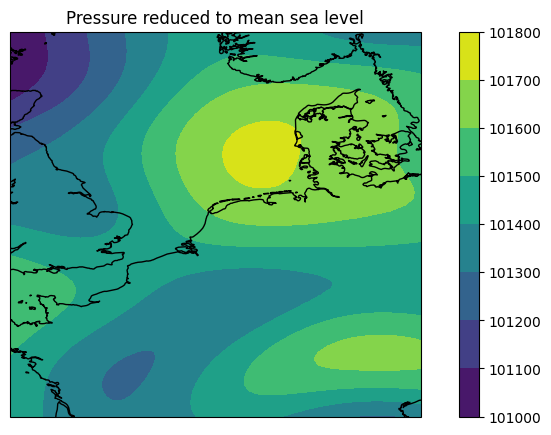

In [45]:
# prompt: plotar a variável PRMSLmsl Pressure reduced to MSL do arquivo $selected_file

import pygrib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Open the GRIB2 file
grbs = pygrib.open(selected_file)

# Find the message containing the desired variable
# Initialize data, lat, and lon to None for error checking
data = None
lat = None
lon = None

for grb in grbs:
  #print(grb.name)
  if grb.name == 'Pressure reduced to MSL':
    # Read the data
    data = grb.values
    lat, lon = grb.latlons()
    break

# Close the file
grbs.close()

# Check if data, lat, and lon were found
if data is None or lat is None or lon is None:
  print("Error: Could not find 'Pressure reduced to mean sea level' variable in the GRIB2 file.")
else:
  # Create a plot
  plt.figure(figsize=(10, 5))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.coastlines()
  cs = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree())
  plt.colorbar(cs)
  plt.title('Pressure reduced to mean sea level')
  plt.show()


In [42]:
%mkdir /content/drive/MyDrive/gis4wrf/datasets/met/ds083.3/201807151200_201807151800
%cp gdas1*.grib2 /content/drive/MyDrive/gis4wrf/datasets/met/ds083.3/201807151200_201807151800/.

mkdir: cannot create directory ‘/content/drive/MyDrive/gis4wrf/datasets/met/ds083.3/201807151200_201807151800’: File exists
